# Astrohackweek 2020 - Exploring Normalizing Flows

In [1]:
# If you don't have nflows installed, uncomment this to install it with pip
#!pip install nflows

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import distributions
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.autoregressive import MaskedPiecewiseLinearAutoregressiveTransform
from nflows.transforms.autoregressive import MaskedPiecewiseQuadraticAutoregressiveTransform
from nflows.transforms.autoregressive import MaskedPiecewiseCubicAutoregressiveTransform
from nflows.transforms import PiecewiseRationalQuadraticCouplingTransform
from nflows.utils import create_alternating_binary_mask
from nflows.nn.nets import ResidualNet

In [4]:
# The BoxUniform distribution in nflows is broken... patch it
class PatchedBoxUniform(BoxUniform):
    def log_prob(self, noise, context):
        return super().log_prob(noise)

# Load the dataset

We will use a simulated isochrone dataset from Miles Cranmer that can be found here: https://github.com/MilesCranmer/xd_vs_flow

In [3]:
# Download the dataset
!wget https://github.com/MilesCranmer/xd_vs_flow/raw/master/quick_isochrone.npy -O quick_isochrone.npy

--2020-09-04 09:59:14--  https://github.com/MilesCranmer/xd_vs_flow/raw/master/quick_isochrone.npy
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MilesCranmer/xd_vs_flow/master/quick_isochrone.npy [following]
--2020-09-04 09:59:14--  https://raw.githubusercontent.com/MilesCranmer/xd_vs_flow/master/quick_isochrone.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.52.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800128 (781K) [application/octet-stream]
Saving to: 'quick_isochrone.npy'

100%[======================================>] 800,128     --.-K/s   in 0.02s   

2020-09-04 09:59:14 (31.4 MB/s) - 'quick_isochrone.npy' saved [800128/800128]



In [5]:
data = np.load('./quick_isochrone.npy')

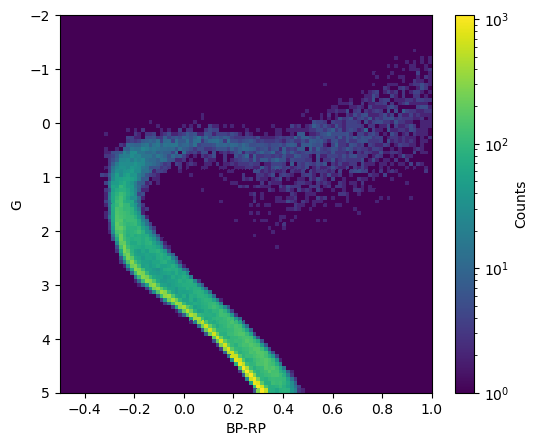

In [6]:
# Let's plot it
import matplotlib as mpl
plt.figure(figsize=(6, 5), dpi=100)
h, xe, ye = np.histogram2d(data[:,1], data[:,0], bins=100, range=[[-0.5, 1.0], [-2, 5]])
plt.pcolormesh(xe, ye, h.T+1, norm=mpl.colors.LogNorm());
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel('G')
plt.colorbar(label='Counts')

# Choose a flow

In this notebook, we consider several different implementations of autoregressive flows. An autoregressive flow transforms some input distribution $x$ into an output distribution $z$ by applying a bijective transformation to x (i.e. a one-to-one invertible transformation). That transformation can be parametrized using a neural network, and with the right setup we can model arbitrary distributions for $z$ even when $x$ is chosen to be a simple distribution like a multivariate Gaussian.

In an autoregressive transformation, we use a transformation with the following form:
$$z_i = \tau(x_i; h_i)$$
where $h_i$ is given by:
$$h_i = c_i(x_{<i})$$

By $x_{<i}$, we mean that $c_i$ can be an arbitrary function (not necessarily invertible) of any of the inputs $x_j$ satisfying $j < i$. We use a neural network to model $c_i$.

$\tau(x_i; h_i)$ has to be a bijective function that maps $x_i$ to $z_i$, and $h_i$ are then a set of parameters that modify this function. One simple form for $\tau(x_i; h_i)$ is a linear (affine) transformation:

$$\tau(x_i; h_i) = h_{i,0} x_i + h_{i,1}$$

However, $\tau(x_i; h_i)$ can be any arbitrary monotonically increasing function. In this notebook, we use nflows to implement a series of different functions for $\tau(x_i; h_i)$ and compare them.

For high-dimensional distributions, there are different functional forms for $c_i(x_{<i})$, but for a 2D distribution like the isochrome one that we are using, these all end up working the same way since we can only use one other dimension at a time.

In [7]:
# Affine transform

num_layers = 10
base_dist = StandardNormal(shape=[2])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, hidden_features=20))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [8]:
# Neural spline flow - linear

num_layers = 10
base_dist = PatchedBoxUniform(
    low=torch.zeros(2),
    high=torch.ones(2),
)
#base_dist = StandardNormal(shape=[2])


transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedPiecewiseLinearAutoregressiveTransform(10, features=2, hidden_features=20))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [7]:
# Neural spline flow - quadratic

num_layers = 10
base_dist = PatchedBoxUniform(
    low=torch.zeros(2),
    high=torch.ones(2),
)

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedPiecewiseQuadraticAutoregressiveTransform(features=2, hidden_features=20))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [ ]:
# Neural spline flow - cubic

num_layers = 10
base_dist = PatchedBoxUniform(
    low=torch.zeros(2),
    high=torch.ones(2),
)
#base_dist = StandardNormal(shape=[2])


transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedPiecewiseCubicAutoregressiveTransform(10, features=2, hidden_features=20))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [ ]:
# Neural spline flow - quadratic from NSF paper with ResidualNet block

num_layers = 5
base_dist = PatchedBoxUniform(
    low=torch.zeros(2),
    high=torch.ones(2),
)
base_dist = StandardNormal(shape=[2])

transforms = []
for i in range(num_layers):
    transforms.append(PiecewiseRationalQuadraticCouplingTransform(
        mask=create_alternating_binary_mask(features=2, even=(i % 2 == 0)),
        transform_net_create_fn=(
            lambda in_features, out_features: ResidualNet(
                in_features=in_features,
                out_features=out_features,
                hidden_features=64,
                num_blocks=2,
                dropout_probability=0.,
                use_batch_norm=0,
            )
        ),
        num_bins=128,
        apply_unconditional_transform=False,
    ))
                      
    #transforms.append(ReversePermutation(features=2))
    #transforms.append(MaskedPiecewiseLinearAutoregressiveTransform(10, features=2, hidden_features=4))
                      
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

# Train the flow

Epoch 0: 5.007121569066047


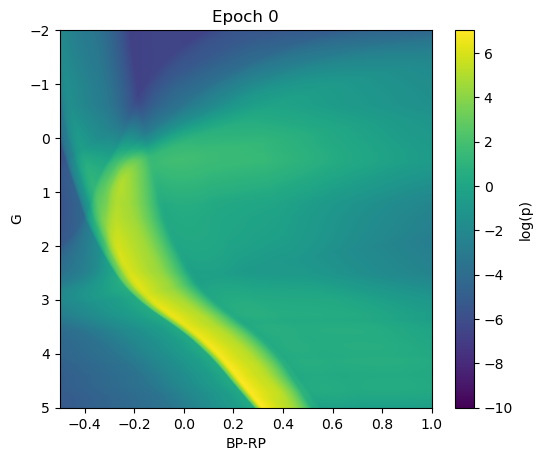

Epoch 1: 5.386689201965332


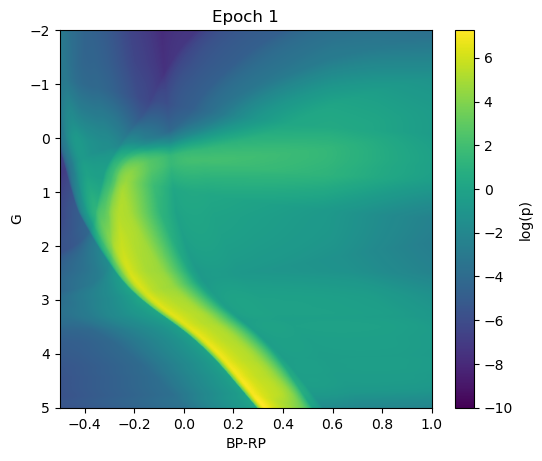

Epoch 2: 5.502546212158203


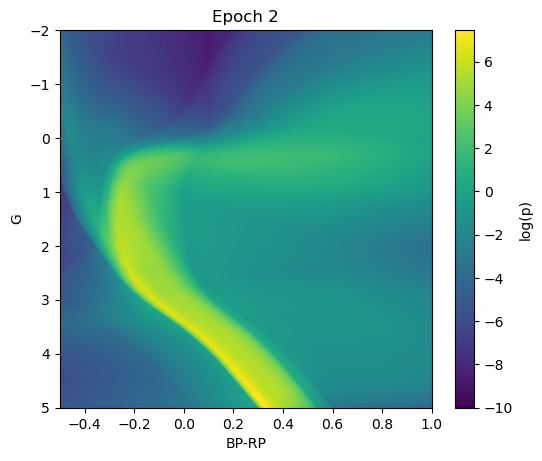

Epoch 3: 5.514590916137696


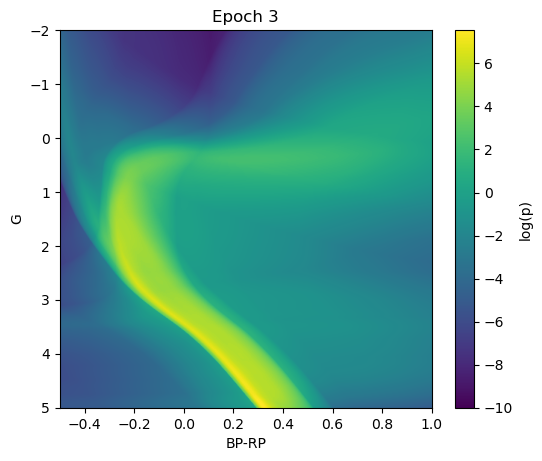

Epoch 4: 5.635439177246094


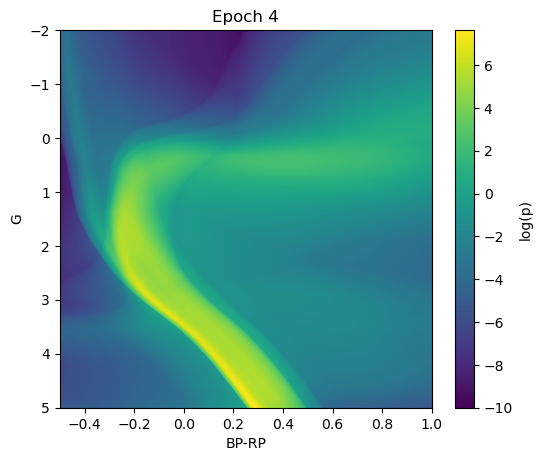

Epoch 5: 5.670188515625


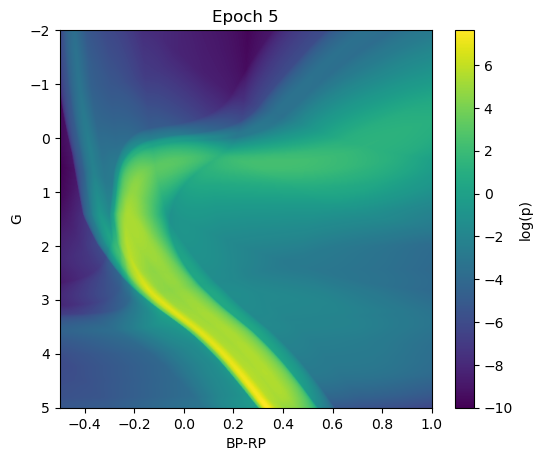

Epoch 6: 5.686105983276367


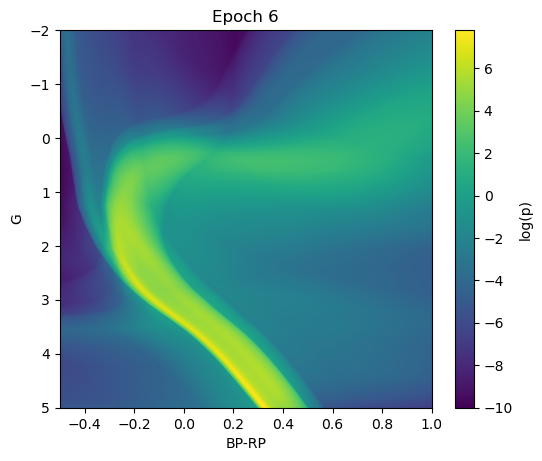

Epoch 7: 5.712025583496094


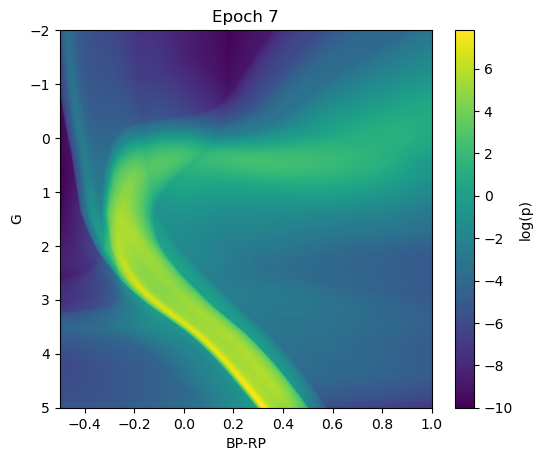

Epoch 8: 5.725728027954101


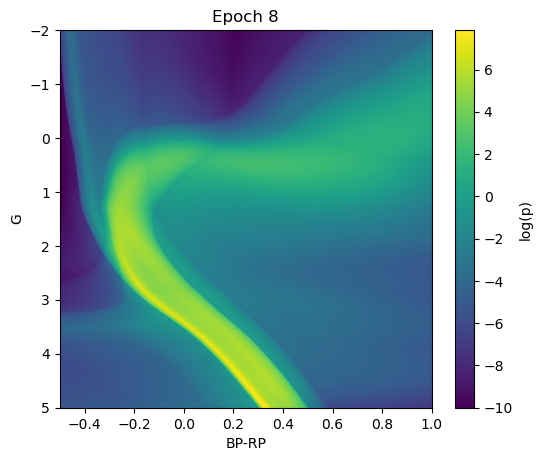

Epoch 9: 5.718231990966797


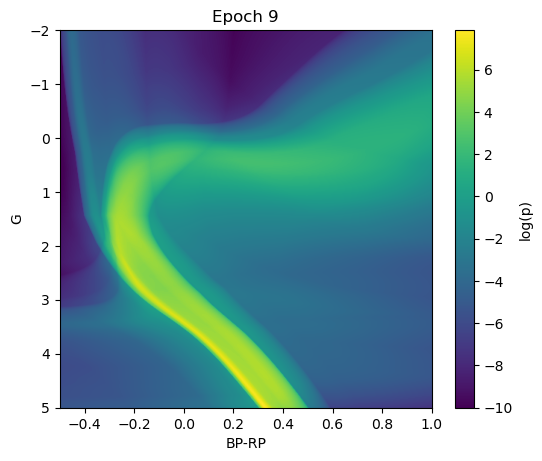

In [8]:
epochs = 10
batch_size = 128

for epoch in range(epochs):
    sum_log_prob = 0.
    for i in range(len(data) // batch_size):
        x = data[i*batch_size:(i+1)*batch_size] / 15 + 0.5
        x = torch.tensor(x, dtype=torch.float32)
        optimizer.zero_grad()
        log_prob = flow.log_prob(inputs=x)
        sum_log_prob += log_prob.detach().numpy().sum()
        loss = -log_prob.mean()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}: {sum_log_prob / len(data)}")

    # Plot the log density
    grid_size = 500
    xline = torch.linspace(-0.5, 1.0, grid_size)
    yline = torch.linspace(-2, 5, grid_size)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([ygrid.reshape(-1, 1), xgrid.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        zgrid = flow.log_prob(xyinput / 15 + 0.5).reshape(grid_size, grid_size)

    plt.figure(figsize=(6, 5), dpi=100)
    plt.imshow(zgrid.numpy().T[::-1], extent=[-0.5, 1.0, -2, 5], aspect='auto', vmin=-10)
    plt.title(f'Epoch {epoch}')
    plt.gca().invert_yaxis()
    plt.colorbar(label='log(p)')
    plt.xlabel('BP-RP')
    plt.ylabel('G')
    plt.show()

# Gradients

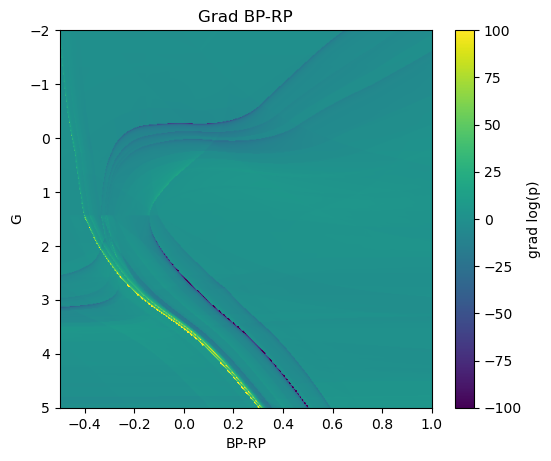

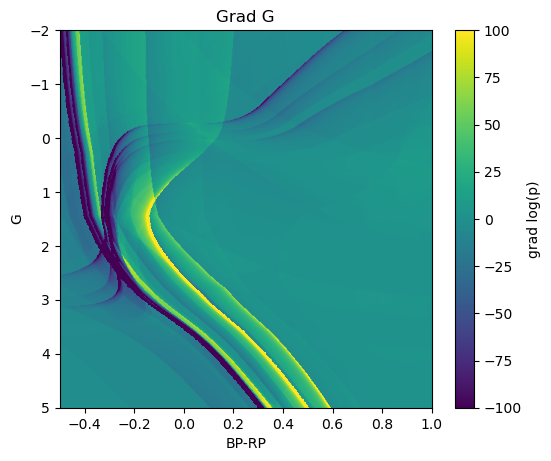

In [10]:
grid_size = 500

xline = torch.linspace(-0.5, 1.0, grid_size)
yline = torch.linspace(-2, 5, grid_size)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([ygrid.reshape(-1, 1), xgrid.reshape(-1, 1)], dim=1)
xyinput.requires_grad = True

log_prob = -flow.log_prob(xyinput / 15 + 0.5).sum()
log_prob.backward()

grad = xyinput.grad.reshape((grid_size, grid_size, 2))

for i in range(2):
    plt.figure(figsize=(6, 5), dpi=100)
    plt.imshow(grad[:, :, i].numpy().T[::-1], extent=[-0.5, 1.0, -2, 5], aspect='auto', vmin=-100, vmax=100)
    titles = ['BP-RP', 'G']
    # Is this order right?
    plt.title(f'Grad {titles[i]}')
    plt.gca().invert_yaxis()
    plt.colorbar(label='grad log(p)')
    plt.xlabel('BP-RP')
    plt.ylabel('G')
    plt.show()